## Fashion MNIST MLP Classification using PyTorch


In [1]:
import torch
import torch.nn.functional as F

from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler  # For validation set

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# transforms.ToTensor(): Separates the image into three color channels,
# then it converts the pixels of each image to the brightness of their color between 0 and 255. 
# These values are then scaled down to a range between 0 and 1.
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,),)])

train_set = datasets.FashionMNIST('./data', download=True, train=True, transform=transform)
test_set = datasets.FashionMNIST('./data', download=True, train=False, transform=transform)

# Prepare our validation set
indices = list(range(len(train_set)))
print('Before shuffle:', indices[:15])

np.random.shuffle(indices)
print('After shuffle:',indices[:15])

# Put away 20% for validation set 
split = int(np.floor(0.2 * len(train_set)))
train_sample = SubsetRandomSampler(indices[:split])
valid_sample = SubsetRandomSampler(indices[split:])

# batch_size parameter defines how many samples per batch to load
# shuffle parameter reshuffles data with every epoch
train_loader = torch.utils.data.DataLoader(train_set, sampler=train_sample , batch_size=64)
valid_loader = torch.utils.data.DataLoader(train_set, sampler=valid_sample, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True) # 

0it [00:00, ?it/s]

100%|█████████▉| 26394624/26421880 [01:31<00:00, 420048.32it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz



32768it [00:01, 19633.93it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz


/Users/shayanbemanian/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:335: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666647174771/work/torch/csrc/utils/tensor_numpy.cpp:205.)
  return torch.from_numpy(parsed).view(length, num_rows, num_cols)


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!
Before shuffle: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
After shuffle: [46675, 28305, 9300, 22647, 31625, 1935, 51472, 50788, 32141, 45315, 58746, 1242, 33356, 16088, 10297]


8192it [00:01, 7080.96it/s]             
26427392it [01:45, 249520.36it/s]                              
4423680it [00:11, 372082.03it/s]                             

torch.Size([64, 1, 28, 28])
torch.Size([64])


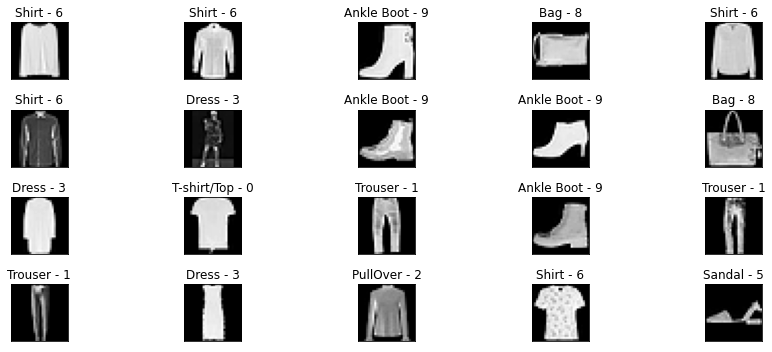

In [3]:
# Let's get a sense of our data
images, labels = next(iter(train_loader))
print(images.shape)
print(labels.shape)

data_dictionary = {
    0: 'T-shirt/Top',
    1: 'Trouser',
    2: 'PullOver',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot'
}

fig = plt.figure(figsize=(15, 5))
for i in range(20):
    ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[i]), cmap='gray')
    ax.set_title(data_dictionary[labels[i].item()] + ' - ' + str(labels[i].item()))

    fig.tight_layout()

In [4]:
input_size = 784 # images are 28 * 28
hidden_sizes = [512, 256, 128, 64]
output_size = 10

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Batch normalization drastically decreases the number of epochs 
        # Also helps avoid overfitting
        # https://www.youtube.com/watch?v=yXOMHOpbon8
        self.batch_norm_0 = nn.BatchNorm1d(input_size)
        self.batch_norm_1 = nn.BatchNorm1d(hidden_sizes[0])
        self.batch_norm_2 = nn.BatchNorm1d(hidden_sizes[1])
        self.batch_norm_3 = nn.BatchNorm1d(hidden_sizes[2])
        self.batch_norm_4 = nn.BatchNorm1d(hidden_sizes[3])

        self.fc0 = nn.Linear(input_size, hidden_sizes[0]) 
        self.fc1 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc2 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.fc3 = nn.Linear(hidden_sizes[2], hidden_sizes[3])
        self.fc4 = nn.Linear(hidden_sizes[3], output_size)
        self.dropout = nn.Dropout(p=0.1) # 10% dropout


    def forward(self, input):
        input = input.view(-1, input_size)
        input = self.dropout(input)

        input = F.relu(self.batch_norm_1(self.fc0(input)))

        input = F.relu(self.batch_norm_2(self.fc1(input)))
        input = self.dropout(input)

        input = F.relu(self.batch_norm_3(self.fc2(input)))

        input = F.relu(self.batch_norm_4(self.fc3(input)))
        input = self.dropout(input)

        input = self.fc4(input)
        return F.log_softmax(input, dim=1)

In [5]:
class EarlyStopper:
    def __init__(self, patience, min_delta):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0

    def early_stop(self, valid_loss, train_loss):
        if (valid_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.patience:  
                return True
            return False

In [6]:
model = Classifier()
criterion = nn.NLLLoss()

model_filename = 'model.pt'

In [7]:
# L2 regularization comes out of the box with PyTorch we just need to use the 'weight_decay' parameter in out optimzier function.
optimizer = optim.SGD(model.parameters(), lr=0.001,  momentum=0.9)
early_stopper = EarlyStopper(5, 1) # Just figured these numbers with multiple trials and errors

epoches = 30
train_losses = []
valid_losses = []

model.train()

for epoch in range(epoches):
    train_loss = 0
    valid_loss = 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)

        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

        # BEGIN the implementation of the L1 regularization

        # l1_lambda = 0.001
        # l1_norm = sum(torch.linalg.norm(p, 1) for p in model.parameters())
        # train_loss += loss.item() + l1_lambda * l1_norm.item()

        # END the implementation of the L1 regularization

    for images, labels in valid_loader:
        output = model(images)
        loss = criterion(output, labels)
        
        valid_loss += loss.item()

        # BEGIN the implementation of the L1 regularization

        # valid_loss += loss.item() + l1_lambda * l1_norm.item()

        # END the implementation of the L1 regularization

    train_loss = (train_loss / len(train_loader.sampler)) * 1000
    valid_loss = (valid_loss / len(valid_loader.sampler)) * 1000
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print('Epoch: ' + str(epoch) + '\t Training loss: ' + str(train_loss) + '\t Validation loss: ' + str(valid_loss))
    if early_stopper.early_stop(valid_loss, train_loss):             
        break

torch.save(model.state_dict(), model_filename)

Epoch: 0	 Training loss: 20.67741449177265	 Validation loss: 14.024623814970255
Epoch: 1	 Training loss: 11.971133947372437	 Validation loss: 10.540370169406135
Epoch: 2	 Training loss: 9.674113521973293	 Validation loss: 9.1830657509466
Epoch: 3	 Training loss: 8.541825763881207	 Validation loss: 8.4683517832309
Epoch: 4	 Training loss: 7.900702618062496	 Validation loss: 7.988093078757325
Epoch: 5	 Training loss: 7.297068019707997	 Validation loss: 7.7312367064878345
Epoch: 6	 Training loss: 6.904286152372758	 Validation loss: 7.54677277089407
Epoch: 7	 Training loss: 6.5777893004318075	 Validation loss: 7.424003503285348
Epoch: 8	 Training loss: 6.170525562018156	 Validation loss: 7.173724883856872
Epoch: 9	 Training loss: 5.830863780031601	 Validation loss: 7.162874682185551
Epoch: 10	 Training loss: 5.736726003388564	 Validation loss: 7.019747212529182
Epoch: 11	 Training loss: 5.601292327046394	 Validation loss: 6.992900526461502
Epoch: 12	 Training loss: 5.334462236613035	 Valid

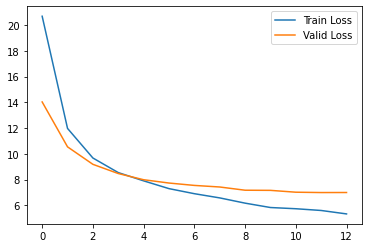

In [8]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')

plt.legend()

In [9]:
model.load_state_dict(torch.load(model_filename))

<All keys matched successfully>

In [10]:
test_loss = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# Deactivates dropout and batchnorm layers
model.eval() 

for images, labels in test_loader:
  output = model(images)
  loss = criterion(output, labels)
  test_loss += loss.item()

  # Convert output probabilities to predicted class
  _, pred = torch.max(output, 1)

  # Compare predictions to the true labes
  correct = np.squeeze(pred.eq(labels.data.view_as(pred)))

  for i in range(len(labels)):
    label = labels.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] +=1

test_loss = (test_loss/len(test_loader.sampler)) * 1000

print('Test Loss: ' + str(test_loss))
print('Test Accuracy (Overall): ' + str(100 * np.sum(class_correct) / np.sum(class_total)) + '%')

Test Loss: 6.254351647198201
Test Accuracy (Overall): 86.0%


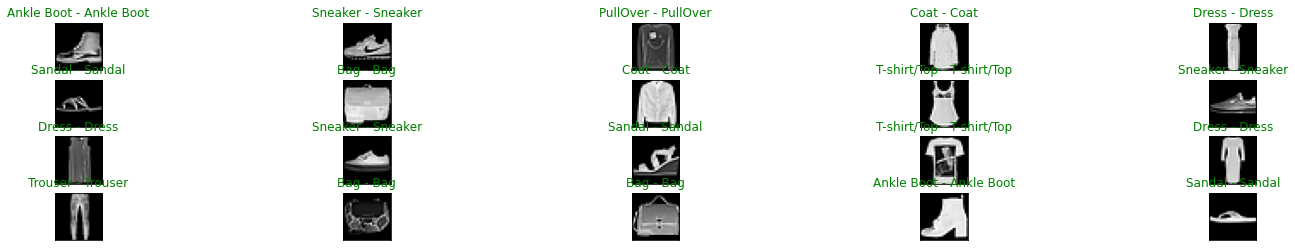

In [11]:
images, labels = next(iter(test_loader))
output = model(images)
_, preds = torch.max(output, 1)
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for i in range(20):
    ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[i]), cmap='gray')
    ax.set_title(data_dictionary[preds[i].item()] + ' - ' + data_dictionary[labels[i].item()], color="green" if preds[i]==labels[i] else "red")